In [1]:
import MDAnalysis as mda
from MDAnalysisTests.datafiles import  TPR, XTC
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from  MDAnalysis.analysis.rdf import InterRDF

In [4]:
from MDAnalysis.lib.util import blocks_of
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import AnalysisBase
from six.moves import zip, range


class newInterRDF(AnalysisBase):
    """Intermolecular pair distribution function
    InterRDF(g1, g2, nbins=75, range=(0.0, 15.0))
    Arguments
    ---------
    g1 : AtomGroup
      First AtomGroup
    g2 : AtomGroup
      Second AtomGroup
    nbins : int (optional)
          Number of bins in the histogram [75]
    range : tuple or list (optional)
          The size of the RDF [0.0, 15.0]
    exclusion_block : tuple (optional)
          A tuple representing the tile to exclude from the distance
          array. [None]
    start : int (optional)
          The frame to start at (default is first)
    stop : int (optional)
          The frame to end at (default is last)
    step : int (optional)
          The step size through the trajectory in frames (default is
          every frame)
    verbose : bool (optional)
          Show detailed progress of the calculation if set to ``True``; the
          default is ``False``.
    Example
    -------
    First create the :class:`InterRDF` object, by supplying two
    AtomGroups then use the :meth:`run` method ::
      rdf = InterRDF(ag1, ag2)
      rdf.run()
    Results are available through the :attr:`bins` and :attr:`rdf`
    attributes::
      plt.plot(rdf.bins, rdf.rdf)
    The `exclusion_block` keyword allows the masking of pairs from
    within the same molecule.  For example, if there are 7 of each
    atom in each molecule, the exclusion mask `(7, 7)` can be used.
    .. versionadded:: 0.13.0
    """
    def __init__(self, g1, g2,
                 nbins=75, range=(0.0, 15.0), exclusion_block=None,
                 **kwargs):
        super(newInterRDF, self).__init__(g1.universe.trajectory, **kwargs)
        self.g1 = g1
        self.g2 = g2
        self.u = g1.universe

        self.rdf_settings = {'bins': nbins,
                             'range': range}
        self._exclusion_block = exclusion_block

    def _prepare(self):
        # Empty histogram to store the RDF
        count, edges = np.histogram([-1], **self.rdf_settings)
        count = count.astype(np.float64)
        count *= 0.0
        self.count = count
        self.edges = edges
        self.bins = 0.5 * (edges[:-1] + edges[1:])

        # Need to know average volume
        self.volume = 0.0
        self._maxrange = self.rdf_settings['range'][1]
        
    def _single_frame(self):
        pairs, dist = distances.capped_distance(self.g1.positions, self.g2.positions,
                                                self._maxrange, 
                                                box=self.u.dimensions)
        
        if self._exclusion_block is not None:
            A, B = pairs[:, 0]//self._exclusion_block[0], pairs[:, 1]//self._exclusion_block[1]
            C = np.where(A != B)[0]
            dist = dist[C]
        
        count = np.histogram(dist, **self.rdf_settings)[0]
        self.count += count

        self.volume += self._ts.volume

    def _conclude(self):
        # Number of each selection
        nA = len(self.g1)
        nB = len(self.g2)
        N = nA * nB

        # If we had exclusions, take these into account
        if self._exclusion_block:
            xA, xB = self._exclusion_block
            nblocks = nA / xA
            N -= xA * xB * nblocks

        # Volume in each radial shell
        vol = np.power(self.edges[1:], 3) - np.power(self.edges[:-1], 3)
        vol *= 4/3.0 * np.pi

        # Average number density
        box_vol = self.volume / self.n_frames
        density = N / box_vol

        rdf = self.count / (density * vol * self.n_frames)

        self.rdf = rdf

In [5]:
u = mda.Universe(TPR, XTC)

In [6]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)
N = np.logspace(2, 4, num=10, dtype=np.int64)
for n in tqdm_notebook(N):
    s1 = u.select_atoms('name OW')[:n]
    
    rdf_old = InterRDF(s1, s1)
    res = %timeit -q -o rdf_old.run()
    result['old'].append(res.average)
    
    rdf_new = newInterRDF(s1, s1)
    res = %timeit -q -o rdf_new.run()
    result['new'].append(res.average)

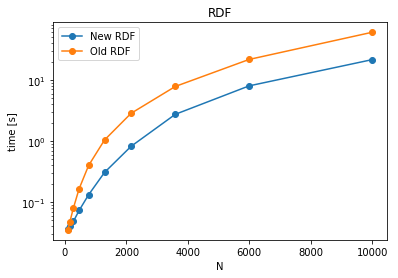

In [7]:
fig, axes = plt.subplots()

axes.plot(N, result['new'], 'o-', label='New RDF')
axes.plot(N, result['old'], 'o-', label='Old RDF')

axes.set(xlabel='N', ylabel='time [s]', yscale='log', title='RDF')
axes.legend()